In [ ]:
import scipy.sparse as sp
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder

import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
import time
import torch.optim as optim
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Utils

In [51]:

def normalize_adjacency(A):
    n = A.shape[0]
    I = sp.identity(n)
    A_tilde = A + I
    degs = (A_tilde).dot(np.ones(n))
    inv_degs = np.power(degs, -0.5)
    D_inv = sp.diags(inv_degs)
    A_normalized = D_inv.dot(A_tilde.dot(D_inv))

    return A_normalized


cora_content_path = '/Users/halvardbariller/Desktop/M2 MVA/_SEMESTER 1/ALTEGRAD/TP/TP5 - DL for Graphs/ALTEGRAD_lab_5_DLForGraphs_2023/code/data/cora.content'
cora_cites_path = '/Users/halvardbariller/Desktop/M2 MVA/_SEMESTER 1/ALTEGRAD/TP/TP5 - DL for Graphs/ALTEGRAD_lab_5_DLForGraphs_2023/code/data/cora.cites'

def load_cora():
    idx_features_labels = np.genfromtxt(cora_content_path, dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    features = features.todense()
    features /= features.sum(1).reshape(-1, 1)
    
    class_labels = idx_features_labels[:, -1]
    le = LabelEncoder()
    class_labels = le.fit_transform(class_labels)

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt(cora_cites_path, dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(class_labels.size, class_labels.size), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    print('Dataset has {} nodes, {} edges, {} features.'.format(adj.shape[0], edges.shape[0], features.shape[1]))

    return features, adj, class_labels


def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


# Models

In [59]:
class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GNN, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj, second_message_passing=False):
        ############## Tasks 10 and 13
 
        z0 = self.fc1(x_in)
        z0 = self.relu(torch.mm(adj, z0))
        z0 = self.dropout(z0)

        z1 = self.fc2(z0)
        z1 = self.relu(torch.mm(adj, z1))

        x = self.fc3(z1)

        if second_message_passing:
            return F.log_softmax(x, dim=1), z1
        else:
            return F.log_softmax(x, dim=1)


# GNN_Karate

In [54]:

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 8
n_hidden_2 = 16
learning_rate = 0.01
dropout_rate = 0.1

# Paths
karate_edges_path = '/Users/halvardbariller/Desktop/M2 MVA/_SEMESTER 1/ALTEGRAD/TP/TP5 - DL for Graphs/ALTEGRAD_lab_5_DLForGraphs_2023/code/data/karate.edgelist'
karate_labels_path = '/Users/halvardbariller/Desktop/M2 MVA/_SEMESTER 1/ALTEGRAD/TP/TP5 - DL for Graphs/ALTEGRAD_lab_5_DLForGraphs_2023/code/data/karate_labels.txt'

# Loads the karate network
G = nx.read_weighted_edgelist(karate_edges_path, delimiter=' ', nodetype=int, create_using=nx.Graph())
print(G.number_of_nodes())
print(G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt(karate_labels_path, delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix


features = np.eye(n) # Generates node features

# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)


# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
test()


34
78
Epoch: 001 loss_train: 0.7104 acc_train: 0.4444 time: 0.0013s
Epoch: 002 loss_train: 0.7037 acc_train: 0.4444 time: 0.0009s
Epoch: 003 loss_train: 0.6992 acc_train: 0.4074 time: 0.0012s
Epoch: 004 loss_train: 0.6937 acc_train: 0.5556 time: 0.0010s
Epoch: 005 loss_train: 0.6904 acc_train: 0.7037 time: 0.0014s
Epoch: 006 loss_train: 0.6855 acc_train: 0.5556 time: 0.0011s
Epoch: 007 loss_train: 0.6829 acc_train: 0.5556 time: 0.0009s
Epoch: 008 loss_train: 0.6749 acc_train: 0.5556 time: 0.0007s
Epoch: 009 loss_train: 0.6646 acc_train: 0.5556 time: 0.0007s
Epoch: 010 loss_train: 0.6595 acc_train: 0.5556 time: 0.0007s
Epoch: 011 loss_train: 0.6595 acc_train: 0.5556 time: 0.0006s
Epoch: 012 loss_train: 0.6371 acc_train: 0.5556 time: 0.0007s
Epoch: 013 loss_train: 0.6282 acc_train: 0.5926 time: 0.0009s
Epoch: 014 loss_train: 0.6093 acc_train: 0.7407 time: 0.0009s
Epoch: 015 loss_train: 0.5960 acc_train: 0.7037 time: 0.0007s
Epoch: 016 loss_train: 0.5774 acc_train: 0.8148 time: 0.0007s
Ep

In [55]:
############## Task 12
# Set the feature of all nodes to the same value

features = np.ones((n,1))
features = torch.FloatTensor(features).to(device)
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
test()

Epoch: 001 loss_train: 0.6880 acc_train: 0.5556 time: 0.0034s
Epoch: 002 loss_train: 0.6838 acc_train: 0.5556 time: 0.0012s
Epoch: 003 loss_train: 0.6944 acc_train: 0.4815 time: 0.0010s
Epoch: 004 loss_train: 0.6796 acc_train: 0.6667 time: 0.0012s
Epoch: 005 loss_train: 0.6876 acc_train: 0.5926 time: 0.0008s
Epoch: 006 loss_train: 0.6762 acc_train: 0.5926 time: 0.0016s
Epoch: 007 loss_train: 0.6852 acc_train: 0.5926 time: 0.0021s
Epoch: 008 loss_train: 0.6846 acc_train: 0.5926 time: 0.0014s
Epoch: 009 loss_train: 0.6747 acc_train: 0.5926 time: 0.0017s
Epoch: 010 loss_train: 0.6836 acc_train: 0.5556 time: 0.0007s
Epoch: 011 loss_train: 0.6820 acc_train: 0.5556 time: 0.0007s
Epoch: 012 loss_train: 0.6840 acc_train: 0.5556 time: 0.0007s
Epoch: 013 loss_train: 0.6951 acc_train: 0.5556 time: 0.0012s
Epoch: 014 loss_train: 0.6871 acc_train: 0.5926 time: 0.0013s
Epoch: 015 loss_train: 0.6782 acc_train: 0.5926 time: 0.0008s
Epoch: 016 loss_train: 0.6752 acc_train: 0.5926 time: 0.0007s
Epoch: 0

# GNN_Cora

In [61]:
# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 64
n_hidden_2 = 32
learning_rate = 0.01
dropout_rate = 0.5

# Read data
features, adj, class_labels = load_cora()
n = adj.shape[0] # Number of nodes
n_class = np.unique(class_labels).size # Number of classes

adj = normalize_adjacency(adj) # Normalize adjacency matrix

# Yields indices to split data into training, validation and test sets
idx = np.random.permutation(n)
idx_train = idx[:int(0.6*n)]
idx_val = idx[int(0.6*n):int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transform the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(class_labels).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output, _ = model(features, adj, second_message_passing=True)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    
    model.eval()
    output,_ = model(features, adj, second_message_passing=True)

    loss_val = F.nll_loss(output[idx_val], y[idx_val])
    acc_val = accuracy_score(torch.argmax(output[idx_val], dim=1).detach().cpu().numpy(), y[idx_val].cpu().numpy())
    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output, embeddings = model(features, adj, second_message_passing=True)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))

    return embeddings[idx_test]


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
embeddings_test = test()


Dataset has 2708 nodes, 5429 edges, 1433 features.
Epoch: 001 loss_train: 1.9473 acc_train: 0.1552 loss_val: 1.9348 acc_val: 0.1624 time: 0.0148s
Epoch: 002 loss_train: 1.9362 acc_train: 0.1570 loss_val: 1.9225 acc_val: 0.1697 time: 0.0119s
Epoch: 003 loss_train: 1.9246 acc_train: 0.1632 loss_val: 1.9090 acc_val: 0.3137 time: 0.0103s
Epoch: 004 loss_train: 1.9117 acc_train: 0.3036 loss_val: 1.8934 acc_val: 0.3173 time: 0.0102s
Epoch: 005 loss_train: 1.8975 acc_train: 0.3005 loss_val: 1.8757 acc_val: 0.3173 time: 0.0101s
Epoch: 006 loss_train: 1.8809 acc_train: 0.3005 loss_val: 1.8562 acc_val: 0.3173 time: 0.0089s
Epoch: 007 loss_train: 1.8632 acc_train: 0.3005 loss_val: 1.8351 acc_val: 0.3173 time: 0.0104s
Epoch: 008 loss_train: 1.8442 acc_train: 0.3005 loss_val: 1.8138 acc_val: 0.3173 time: 0.0109s
Epoch: 009 loss_train: 1.8281 acc_train: 0.3005 loss_val: 1.7953 acc_val: 0.3173 time: 0.0083s
Epoch: 010 loss_train: 1.8114 acc_train: 0.3005 loss_val: 1.7827 acc_val: 0.3173 time: 0.0112s

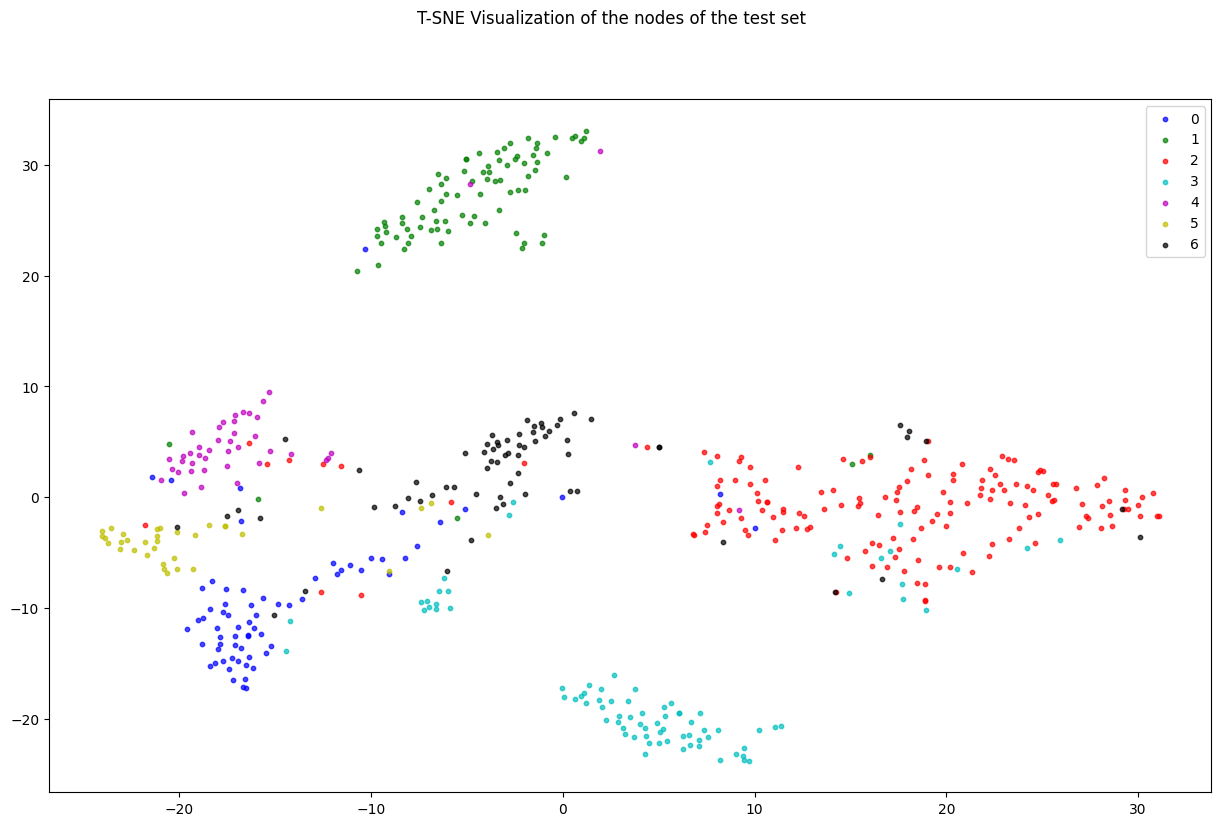

In [62]:

############## Task 13
# Transforms torch tensor to numpy matrix

embeddings_test = embeddings_test.detach().cpu().numpy()

# Projects the emerging representations to two dimensions using t-SNE

embeddings_test_2d = TSNE(n_components=2).fit_transform(embeddings_test)


labels = class_labels[idx_test]
unique_labels = np.unique(labels)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig, ax = plt.subplots()
for i in range(unique_labels.size):
    idxs = [j for j in range(labels.size) if labels[j]==unique_labels[i]]
    ax.scatter(embeddings_test_2d[idxs,0], 
               embeddings_test_2d[idxs,1], 
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization of the nodes of the test set',fontsize=12)
fig.set_size_inches(15,9)
plt.show()
